# Домашнее задание Customer segmentation clustering

## Импорт библиотек

In [ ]:
!pip install -q phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.8/679.8 kB 7.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
import phik
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD, LatentDirichletAllocation, SparsePCA, NMF
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
from mpl_toolkits import mplot3d
import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
plt.style.use('ggplot')

%matplotlib inline

In [ ]:
RANDOM_STATE=42

## Загрузим данные

Column<br>
```ID``` - Уникальный идентификатор клиента<br>
```Gender``` - Пол клиента<br>
```Ever_Married``` - Семейное положение<br>
```Age``` - Возраст клиента<br>
```Graduated``` - Окончил университет или нет<br>
```Profession``` - Профессия<br>
```Work_Experience``` - Опыт работы в годах<br>
```Spending_Score``` - Оценка расходов клиента<br>
```Family_Size``` - Количество членов семьи клиента (включая клиента)<br>
```Var_1``` - Анонимизированная категория для клиента

In [ ]:
df = pd.read_csv("customer_dataset.csv")

In [ ]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 630.4+ KB


In [ ]:
df.drop("ID", axis=1, inplace=True)

Имеем пропуски как в категориальных, так и в числовых признаках 😞

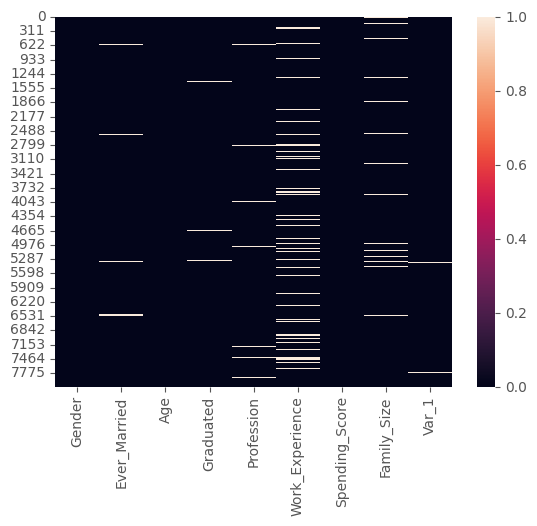

In [ ]:
sns.heatmap(df.isna());

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.values
cat_cols = df.select_dtypes(include=[object]).columns.values

In [ ]:
print("num features:", *list(num_cols))
print("cat features:", *list(cat_cols))

num features: Age Work_Experience Family_Size
cat features: Gender Ever_Married Graduated Profession Spending_Score Var_1


In [ ]:
df.describe()

,Age,Work_Experience,Family_Size
count,8068.000000,7239.000000,7733.000000
mean,43.466906,2.641663,2.850123
std,16.711696,3.406763,1.531413
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


In [ ]:
df.describe(include=[object])

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1
count,8068,7928,7990,7944,8068,7992
unique,2,2,2,9,3,7
top,Male,Yes,Yes,Artist,Low,Cat_6
freq,4417,4643,4968,2516,4878,5238


interval columns not set, guessing: ['ID', 'Age', 'Work_Experience', 'Family_Size']


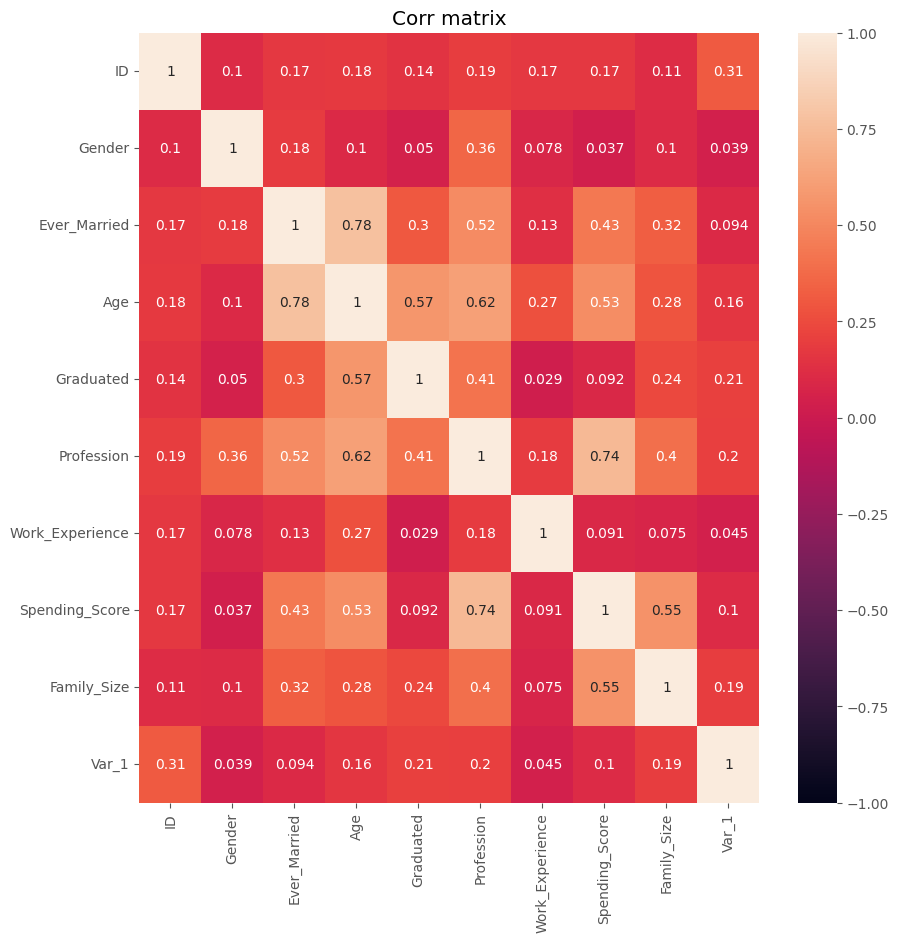

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.phik_matrix(), annot=True, vmin=-1, vmax=1,)
plt.title("Corr matrix");

In [ ]:
df_imp = df.copy()
impute_num = SimpleImputer(strategy='mean')
impute_cat = SimpleImputer(strategy='most_frequent')

df_imp[num_cols] = impute_num.fit_transform(df_imp[num_cols])
df_imp[cat_cols] = impute_cat.fit_transform(df_imp[cat_cols])

df_imp.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,Male,No,22.0,No,Healthcare,1.000000,Low,4.0,Cat_4
1,Female,Yes,38.0,Yes,Engineer,2.641663,Average,3.0,Cat_4
2,Female,Yes,67.0,Yes,Engineer,1.000000,Low,1.0,Cat_6
3,Male,Yes,67.0,Yes,Lawyer,0.000000,High,2.0,Cat_6
4,Female,Yes,40.0,Yes,Entertainment,2.641663,High,6.0,Cat_6


In [ ]:
X = pd.get_dummies(df_imp, columns=cat_cols)

## Попробуем различные модели кластеризации

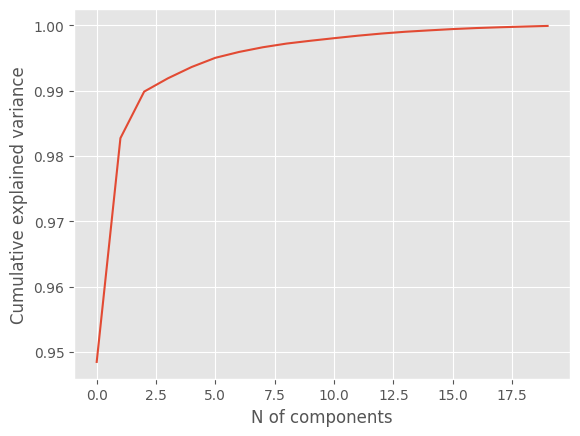

In [ ]:
pca = PCA(20)
pca_full = pca.fit(X)

plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('N of components')
plt.ylabel('Cumulative explained variance');

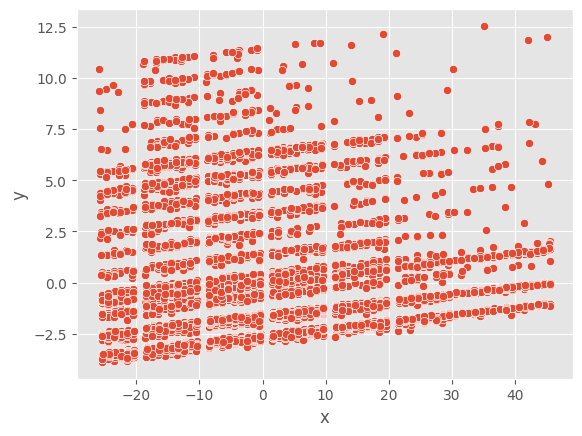

In [ ]:
pca = PCA(2)
X_pca = pd.DataFrame(pca.fit_transform(X), columns=['x', 'y'])
sns.scatterplot(data=X_pca, x='x', y='y');

Видим, что выделяются некоторые кластеры (к сожалению, это не то, что нужно) 😞

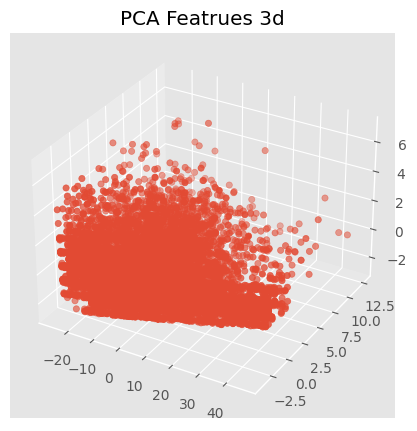

In [ ]:
pca = PCA(3)
X_pca = pd.DataFrame(pca.fit_transform(X), columns=['x', 'y', 'z'])

fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection="3d")

ax.scatter3D(X_pca.x, X_pca.y, X_pca.z)
plt.title("PCA Featrues 3d")

plt.show();

Попробуем кластеризовать без преобразований

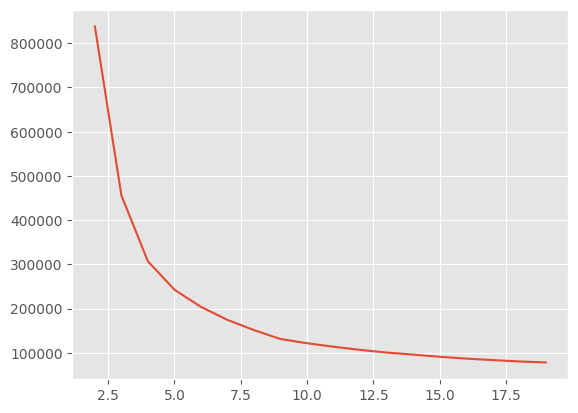

In [ ]:
K = range(2, 20)
inertia = []

for k in K:
  model = KMeans(k)
  model.fit(X)
  inertia.append(model.inertia_)

plt.plot(K, inertia);

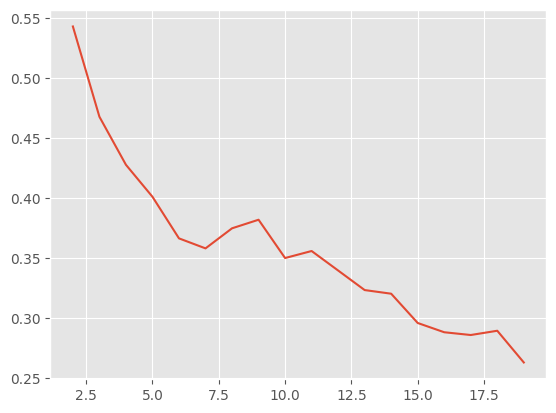

In [ ]:
K = range(2, 20)
silhouette = []

for k in K:
  model = KMeans(k)
  model.fit(X)
  silhouette.append(metrics.silhouette_score(X, model.labels_))

plt.plot(K, silhouette);

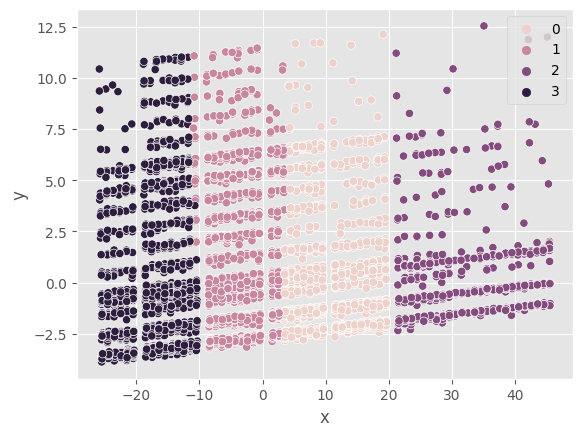

In [ ]:
pca = PCA(2)
X_pca = pd.DataFrame(pca.fit_transform(X), columns=['x', 'y'])
model1 = KMeans(4)
model1.fit(X_pca)
sns.scatterplot(data=X_pca, x='x', y='y', hue=model1.labels_);

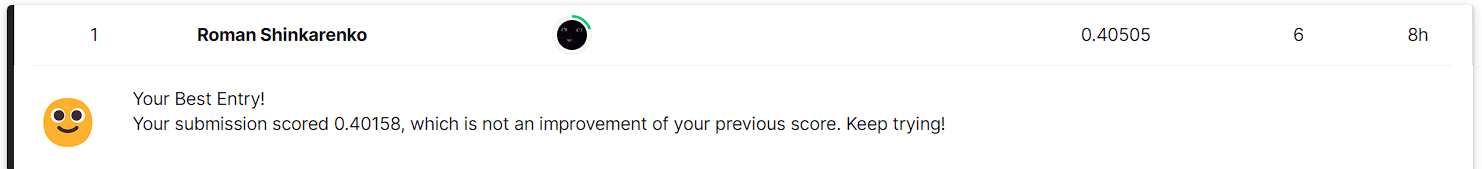

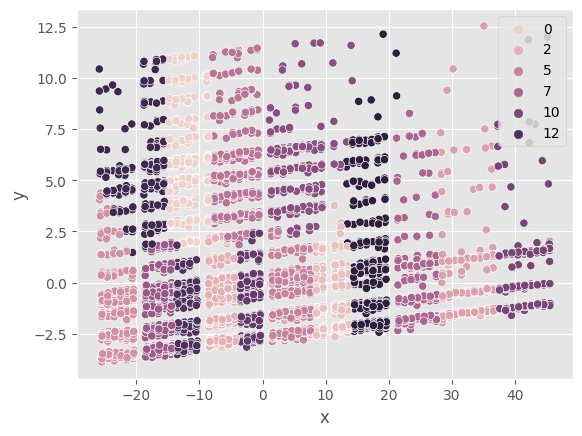

In [ ]:
pca = PCA(2)
X_pca = pd.DataFrame(pca.fit_transform(X), columns=['x', 'y'])
model1 = KMeans(15)
model1.fit(X_pca)
sns.scatterplot(data=X_pca, x='x', y='y', hue=model1.labels_);

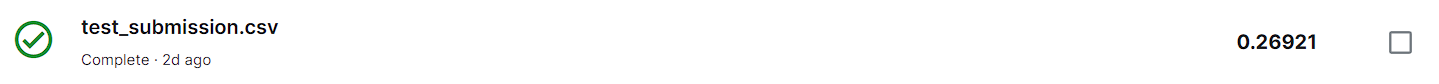

Видим, что кластеры не выделяются, попробуем другие преобразования

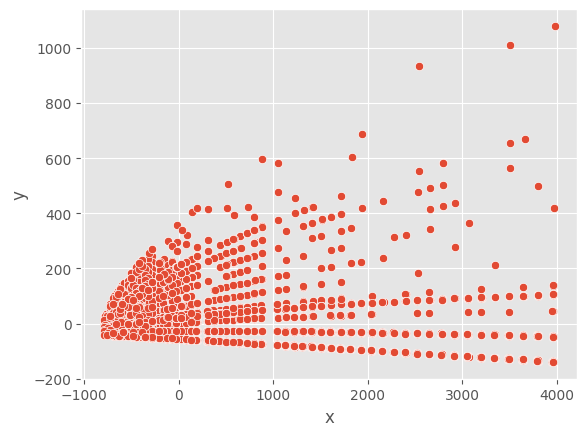

In [ ]:
pca = KernelPCA(2, kernel='poly')
X_pca = pd.DataFrame(pca.fit_transform(X), columns=['x', 'y'])
model1 = KMeans(15)
model1.fit(X_pca)
sns.scatterplot(data=X_pca, x='x', y='y');

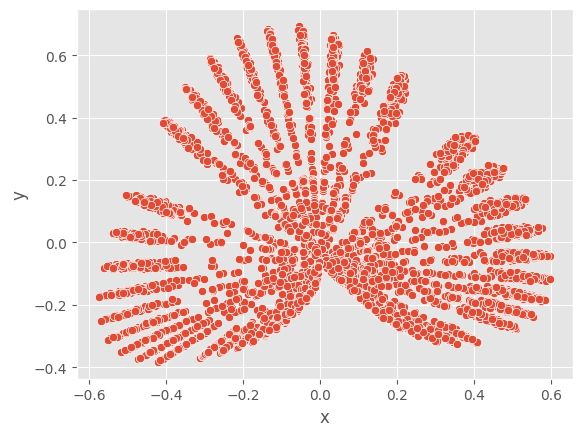

In [ ]:
pca = KernelPCA(2, kernel='rbf')
X_pca = pd.DataFrame(pca.fit_transform(X), columns=['x', 'y'])
model1 = KMeans(15)
model1.fit(X_pca)
sns.scatterplot(data=X_pca, x='x', y='y');

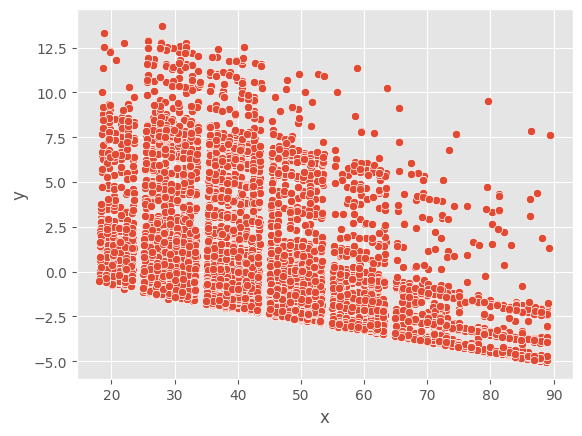

In [ ]:
pca = TruncatedSVD(2)
X_pca = pd.DataFrame(pca.fit_transform(X), columns=['x', 'y'])
model1 = KMeans(15)
model1.fit(X_pca)
sns.scatterplot(data=X_pca, x='x', y='y');

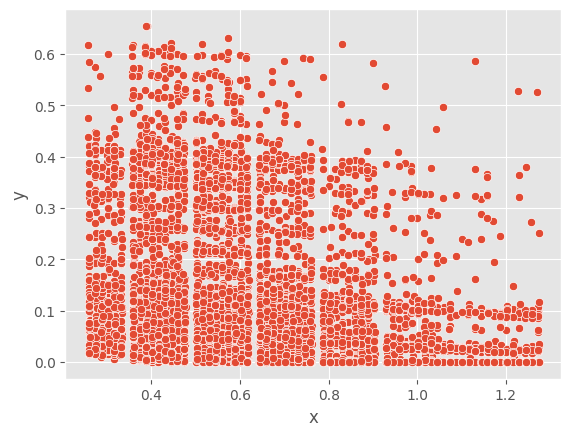

In [ ]:
pca = NMF(2)
X_pca = pd.DataFrame(pca.fit_transform(X), columns=['x', 'y'])
model1 = KMeans(15)
model1.fit(X_pca)
sns.scatterplot(data=X_pca, x='x', y='y');

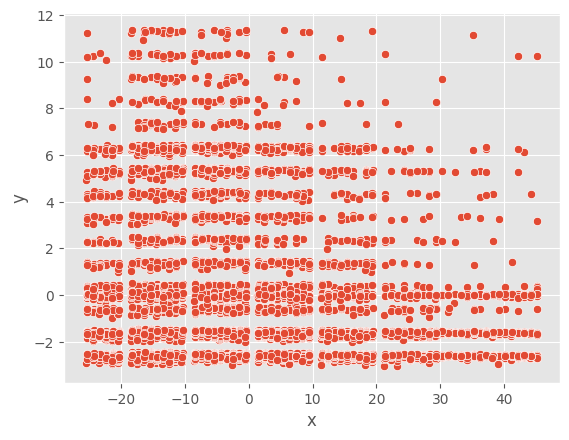

In [ ]:
pca = SparsePCA(2)
X_pca = pd.DataFrame(pca.fit_transform(X), columns=['x', 'y'])
model1 = KMeans(15)
model1.fit(X_pca)
sns.scatterplot(data=X_pca, x='x', y='y');

In [ ]:
final_model = KMeans(4)
final_model.fit(X)
def encode_labels(labels):
  l = list(pd.Series(labels).unique())
  new_labels = []
  for t in labels:
     new_labels.append(l.index(t) + 1)
  return new_labels
df = pd.read_csv('customer_dataset.csv')

subm = pd.DataFrame({"ID": df.ID, "Segmentation": model1.labels_})
subm['Segmentation'] = encode_labels(subm['Segmentation'])

In [ ]:
subm

,ID,Segmentation
0,462809,1
1,462643,2
2,466315,3
3,461735,3
4,462669,4
...,...,...
8063,464018,1
8064,464685,2
8065,465406,6
8066,467299,7


### Читы 😈

In [ ]:
cheat_df = pd.read_csv("Train.csv")

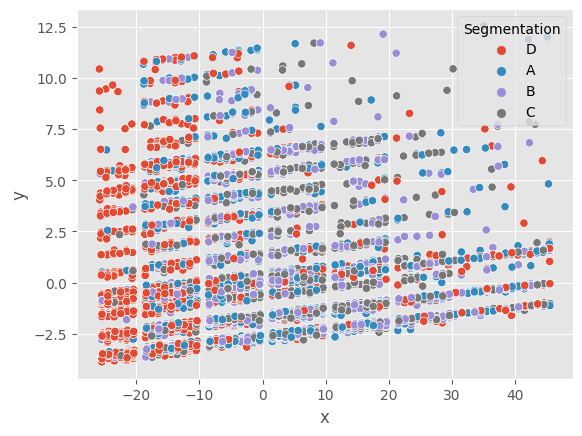

In [ ]:
pca = PCA(2)
X_pca = pd.DataFrame(pca.fit_transform(X), columns=['x', 'y'])
sns.scatterplot(data=X_pca, x='x', y='y', hue=cheat_df.Segmentation);

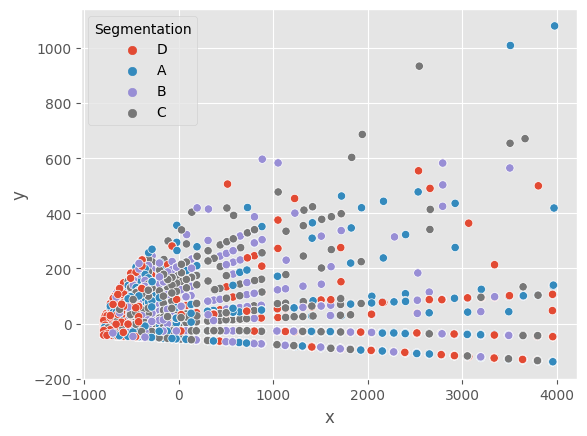

In [ ]:
pca = KernelPCA(2, kernel='poly')
X_pca = pd.DataFrame(pca.fit_transform(X), columns=['x', 'y'])
sns.scatterplot(data=X_pca, x='x', y='y', hue=cheat_df.Segmentation);

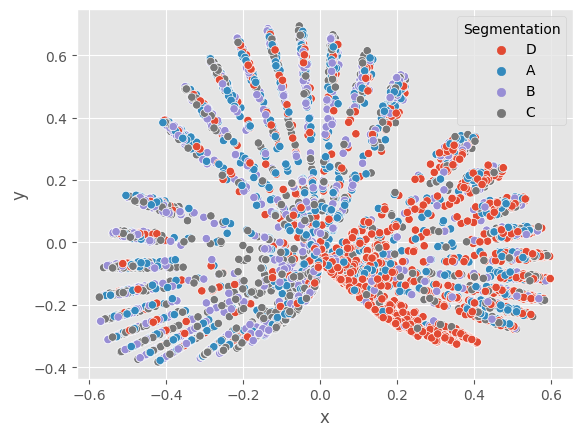

In [ ]:
pca = KernelPCA(2, kernel='rbf')
X_pca = pd.DataFrame(pca.fit_transform(X), columns=['x', 'y'])
sns.scatterplot(data=X_pca, x='x', y='y', hue=cheat_df.Segmentation);

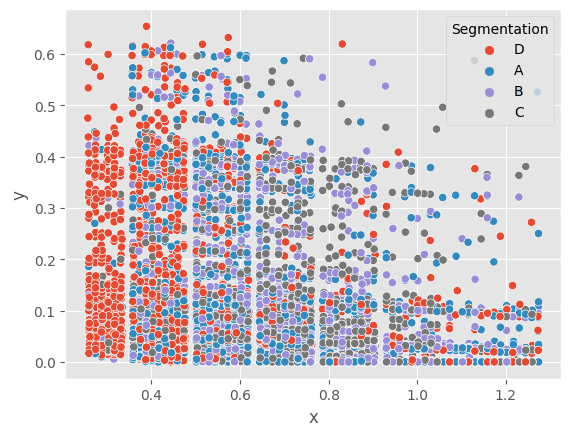

In [ ]:
pca = NMF(2)
X_pca = pd.DataFrame(pca.fit_transform(X), columns=['x', 'y'])
# model1 = KMeans(15)
# model1.fit(X_pca)
sns.scatterplot(data=X_pca, x='x', y='y', hue=cheat_df.Segmentation);